[View in Colaboratory](https://colab.research.google.com/github/samik-saha/kaggle/blob/master/rsna/colab_RSNA_pneumonia_detecion.ipynb)

## Download data and dependencies
Download data files from kaggle and required libraries

In [1]:
!pip install kaggle
!export KAGGLE_USERNAME="samik01";export KAGGLE_KEY="77cc422dd5d3f614b716fd353fe4e034";kaggle competitions download -c rsna-pneumonia-detection-challenge

GCP%20Credits%20Request%20Link%20-%20RSNA.txt: Skipping, found more recently modified local copy (use --force to force download)
stage_1_detailed_class_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_1_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
stage_1_train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_1_test_images.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_1_train_images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
![[ -e stage_1_train_images ]] || unzip stage_1_train_images.zip -d stage_1_train_images>/dev/null
![[ -e stage_1_train_labels.csv ]] || unzip stage_1_train_labels.csv.zip>/dev/null
![[ -e stage_1_detailed_class_info.csv ]] || unzip stage_1_detailed_class_info.csv.zip>/dev/null

In [3]:
!ls

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
sample_data				       stage_1_train_images
stage_1_detailed_class_info.csv		       stage_1_train_images.zip
stage_1_detailed_class_info.csv.zip	       stage_1_train_labels.csv
stage_1_sample_submission.csv		       stage_1_train_labels.csv.zip


In [4]:
!pip install pydicom

##Code


In [5]:

import pandas as pd
import pydicom, numpy as np
import matplotlib.pyplot as plt
import random
import keras
import tensorflow as tf
from skimage.transform import resize


Using TensorFlow backend.


In [0]:
def parse_data(df):
    extract_box = lambda row: [row['x'], row['y'], row['height'], row['width']]
    parsed = {}
    
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom':'./stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []
            }
            
        if row['Target'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
                
    return parsed


def draw(data):
    """
    Method to draw image for single patient
    """
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    
    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)
    
    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

    
def overlay_box(im, box, rgb, stroke=1):
    box = [int(b) for b in box]
    x1, y1, height, width = box
    x2 = x1 + width
    y2 = y1 + height
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb
    
    return im

In [7]:
df = pd.read_csv('stage_1_train_labels.csv')
patient_class = pd.read_csv('stage_1_detailed_class_info.csv', index_col=0)
parsed = parse_data(df)
patient_ids = list(parsed.keys())
random.shuffle(patient_ids)
n_valid_samples = 2560
train_patient_ids = patient_ids[n_valid_samples:]
valid_patient_ids = patient_ids[:n_valid_samples]
print ("No. of training samples: %s" % len(train_patient_ids))
print ("No. of validation samples: %s" % len(valid_patient_ids))
n_train_samples = len(train_patient_ids) - n_valid_samples

No. of training samples: 23124
No. of validation samples: 2560


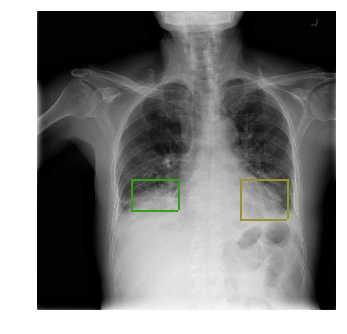

In [8]:
draw(parsed[df['patientId'][8]])

In [0]:
class generator(keras.utils.Sequence):
  def __init__(self, data, patient_ids, batch_size=32, image_size=256, shuffle=True, 
               augment=False, predict=False):
    self.data = data
    self.patient_ids = patient_ids
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.augment = augment
    self.predict = predict
    self.on_epoch_end()
  
  def __load__(self, patient_id):
    example = self.data[patient_id]
    # load dicom file as numpy array
    img = pydicom.dcmread(example['dicom']).pixel_array
    # create empty mask
    msk = np.zeros(img.shape)
    # if image contains boxes
    for box in example['boxes']:
      x, y, h, w = [int(b) for b in box]
      msk[y:y+h, x:x+w] = 1
    
    # resize both image and mask
    img = resize(img, (self.image_size, self.image_size), mode = 'reflect')
    msk = resize(msk, (self.image_size, self.image_size), mode = 'reflect')> 0.5
    
    # if augment flip horizontally half the time
    if self.augment and random.random()>0.5:
      img = np.fliplr(img)
      msk = np.fliplr(msk)
      
    img = np.expand_dims(img, -1)
    msk = np.expand_dims(msk, -1)
    
    return img, msk
  
  def __loadpredict__(self, patient_id):
    example = self.data[patient_id]
    img = pydicom.dcmread(example['dicom']).pixel_array
    img = resize(img, (self.image_size, self.image_size), mode='reflect')
    img = np.expand_dims(img, -1)
    return img
    
  def __getitem__(self, index):
    patient_ids = self.patient_ids[index * self.batch_size : (index+1) * self.batch_size]
    if self.predict:
      imgs = [self.__loadpredict__(patient_id) for patient_id in patient_ids]
      imgs = np.array(imgs)
      return imgs, patient_ids
    else:
      items = [self.__load__(patient_id) for patient_id in patient_ids]
      imgs, msks = zip (*items)
      imgs = np.array(imgs)
      msks = np.array(msks)
      return imgs, msks
    
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.patient_ids)
      
  def __len__(self):
    if self.predict:
      return int(np.ceil(len(self.patient_ids)/self.batch_size))
    else:
      return int(len(self.patient_ids)/self.batch_size)
  

80
2560
25684
(32, 256, 256, 1)
(32, 256, 256, 1)


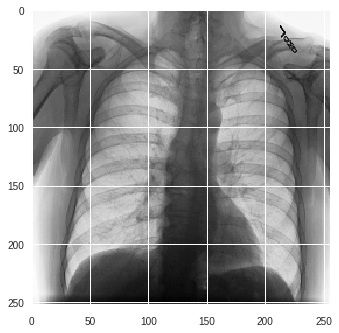

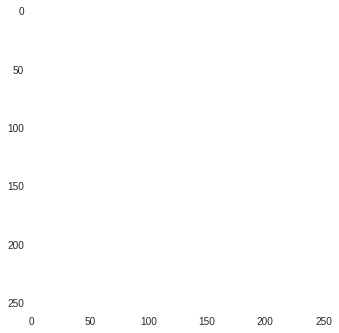

In [18]:
g = generator(parsed, valid_patient_ids)
print(g.__len__())
g.on_epoch_end()
print(len(g.patient_ids))
print(len(patient_ids))
imgs, msks = g.__getitem__(1)
print(imgs.shape)
print(msks.shape)
plt.imshow(np.squeeze(imgs[3]))
plt.figure()
plt.imshow(np.squeeze(msks[3]))


In [0]:
# Create network
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x
  
def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
train_gen = generator(parsed, train_patient_ids, batch_size=32, image_size=256, 
                      shuffle=True, augment=True, predict=False)
valid_gen = generator(parsed, valid_patient_ids, batch_size=32, 
                      image_size=256, shuffle=False, predict=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history = model.fit_generator(train_gen,validation_data=valid_gen, 
                                    callbacks=[learning_rate], epochs=1, workers=1, 
                                    use_multiprocessing=False)

Epoch 1/1
  3/722 [..............................] - ETA: 16:31:43 - loss: 0.9295 - acc: 0.8603 - mean_iou: 0.1071